# SQL Analysis Development Notebook

This notebook is used for testing code concepts for the SQL Analysis module.

## Table of Contents

<ol>
    <li><a href='#start'>Modifying Class Dictionary</a></li>
    <li><a href='#create'>Create Tables</a></li>
    <li><a href='#test'>Test Functionality</a></li>
    <li><a href='#summary'>Summarize Function</a></li>
</ol>

<a id='start'></a>
## Modifying Class Dictionary

In [1]:
class DictTest:
    def __init__(self):
        self.my_dict = {}
        self.label = 'count'
    
    def run_test(self, value):
        if value > 10:
            self.my_dict[self.label] = value

In [2]:
tester = DictTest()

my_list = [1, 15, 6, 8, 20, 13]
my_labels = ['abc', 'xyz', 'def', 'lmn', 'ijk', 'str']

for value, label in zip(my_list, my_labels):
    tester.label = label
    tester.run_test(value)

In [3]:
tester.my_dict

{'xyz': 15, 'ijk': 20, 'str': 13}

<a id='create'></a>
## Create Tables

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
from sqlalchemy import types
import seaborn as sns
import matplotlib.pyplot as plt

import sql_analysis as san
from sql_config_example import ENGINE_DVD

%matplotlib inline

In [148]:
create_str = "\
SELECT \
    CAST(EXTRACT(YEAR FROM r.rental_date) AS TEXT) || '-' ||  CAST(EXTRACT(MONTH FROM r.rental_date) AS TEXT) AS ss_dt \
    , r.rental_id \
    , r.rental_date \
    , f.title \
    , f.length \
    , f.rating \
FROM rental r \
    JOIN inventory i \
        ON i.inventory_id = r.inventory_id \
    JOIN film f \
        ON f.film_id = i.film_id"

df = san.sql_query(create_str, 'dvd')

In [30]:
df.head()

,ss_dt,rental_id,rental_date,title,length,rating
0,2005-5,2,2005-05-24 22:54:33,Freaky Pocus,126,R
1,2005-5,3,2005-05-24 23:03:39,Graduate Lord,156,G
2,2005-5,4,2005-05-24 23:04:41,Love Suicides,181,R
3,2005-5,5,2005-05-24 23:05:21,Idols Snatchers,84,NC-17
4,2005-5,6,2005-05-24 23:08:07,Mystic Truman,92,NC-17


In [19]:
df.rental_date.describe()

count                   16044
unique                  15815
top       2006-02-14 15:16:03
freq                      182
first     2005-05-24 22:53:30
last      2006-02-14 15:16:03
Name: rental_date, dtype: object

Generate random timestamps via this [StackOverflow answer](https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates).

In [20]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [23]:
random_dates = []
for _ in np.arange(df.shape[0]):
    random_dates.append(random_date(df.rental_date.min(),
                                    df.rental_date.max()))

Create alternate view for comparison testing.

In [31]:
alt_rental_view = df.copy()
alt_rental_view['rental_date'] = random_dates
alt_rental_view['ss_date'] = alt_rental_view['rental_date'].dt.year.astype(str) \
                             + '-' + alt_rental_view['rental_date'].dt.month.astype(str)
alt_rental_view.drop('ss_dt', axis=1, inplace=True)

In [32]:
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02 22:58:47,Freaky Pocus,126,R,2005-12
1,3,2005-11-04 04:06:39,Graduate Lord,156,G,2005-11
2,4,2005-10-08 19:37:49,Love Suicides,181,R,2005-10
3,5,2005-09-03 13:17:21,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31 02:40:27,Mystic Truman,92,NC-17,2005-10


Create tables in database

In [39]:
alt_rental_view.to_sql('alt_rental_view', 
                       ENGINE_DVD, 
                       if_exists='replace', 
                       index=False,
                       dtype={"rental_id": types.Integer(),
                              "rental_date": types.Date(),
                              "title": types.VARCHAR(length=255),
                              "length": types.Integer(),
                              "rating": types.VARCHAR(length=6),
                              "ss_date": types.VARCHAR(length=8)})

In [41]:
df.to_sql('rental_view',
          ENGINE_DVD,
          if_exists='replace',
          dtype={"rental_id": types.Integer(),
                 "ss_dt": types.VARCHAR(length=8),
                 "rental_date": types.Date(),
                 "title": types.VARCHAR(length=255),
                 "length": types.Integer(),
                 "rating": types.VARCHAR(length=6)})

Create a third test table.

In [150]:
df.shape

(16044, 6)

In [151]:
drop_ind = np.random.randint(0, df.shape[0], 200)

In [152]:
alt_sim_rental_view = df.drop(drop_ind).copy()

In [155]:
df.columns

Index(['ss_dt', 'rental_id', 'rental_date', 'title', 'length', 'rating'], dtype='object')

In [156]:
alt_sim_rental_view.columns = ['ss_dt', 'id', 'rental_date', 'movie', 'runtime', 'rating']
alt_sim_rental_view.to_sql('alt_sim_rental_view',
                           ENGINE_DVD,
                           if_exists='replace',
                           index=False,
                           dtype={"ss_dt": types.VARCHAR(length=8),
                                  "id": types.Integer(),
                                  "rental_date": types.Date(),
                                  "movie": types.VARCHAR(length=255),
                                  "runtime": types.Integer(),
                                  "rating": types.VARCHAR(length=6)})

<a id='test'></a>
## Test Functionality

In [3]:
rental_view = san.sql_query('SELECT * FROM rental_view', 'dvd')
rental_view.head()

,index,ss_dt,rental_id,rental_date,title,length,rating
0,0,2005-5,2,2005-05-24,Freaky Pocus,126,R
1,1,2005-5,3,2005-05-24,Graduate Lord,156,G
2,2,2005-5,4,2005-05-24,Love Suicides,181,R
3,3,2005-5,5,2005-05-24,Idols Snatchers,84,NC-17
4,4,2005-5,6,2005-05-24,Mystic Truman,92,NC-17


In [4]:
alt_rental_view = san.sql_query('SELECT * FROM alt_rental_view', 'dvd')
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02,Freaky Pocus,126,R,2005-12
1,3,2005-11-04,Graduate Lord,156,G,2005-11
2,4,2005-10-08,Love Suicides,181,R,2005-10
3,5,2005-09-03,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31,Mystic Truman,92,NC-17,2005-10


In [5]:
alt_sim_rental_view = san.sql_query('SELECT * FROM alt_sim_rental_view', 'dvd')
alt_sim_rental_view.head()

,ss_dt,id,rental_date,movie,runtime,rating
0,2005-5,2,2005-05-24,Freaky Pocus,126,R
1,2005-5,3,2005-05-24,Graduate Lord,156,G
2,2005-5,4,2005-05-24,Love Suicides,181,R
3,2005-5,5,2005-05-24,Idols Snatchers,84,NC-17
4,2005-5,6,2005-05-24,Mystic Truman,92,NC-17


In [71]:
reload(san);

In [44]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

tester.run_test()
tester._results

Commencing test for count rental_id...
   Commencing rental_id query...
   Query for rental_id complete.
PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.



,date,ss_dt,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,1156,417,1140,739,63.93,16,1.38
1,04-Aug-19,2005-6,2311,1856,2287,455,19.69,24,1.04
2,04-Aug-19,2005-7,6709,1795,6630,4914,73.24,79,1.18
3,04-Aug-19,2005-8,5686,1835,5610,3851,67.73,76,1.34
4,04-Aug-19,2006-2,182,857,179,-675,-370.88,3,1.65


In [25]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

# Get data for 'count' test
count_df = tester.gather_data()
count_df

Commencing rental_id query...
Query for rental_id complete.



,ss_dt,rvw_count,alt_count,sim_count
0,2005-5,1156,417,1140
1,2005-6,2311,1856,2287
2,2005-7,6709,1795,6630
3,2005-8,5686,1835,5610
4,2006-2,182,857,179


In [26]:
tester.run_test()
tester._results

Commencing test for rental_id...
Commencing rental_id query...
Query for rental_id complete.

PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.



,date,ss_dt,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,1156,417,1140,739,63.93,16,1.38
1,04-Aug-19,2005-6,2311,1856,2287,455,19.69,24,1.04
2,04-Aug-19,2005-7,6709,1795,6630,4914,73.24,79,1.18
3,04-Aug-19,2005-8,5686,1835,5610,3851,67.73,76,1.34
4,04-Aug-19,2006-2,182,857,179,-675,-370.88,3,1.65


<a id='summary'></a>
## Summarize Function

In [79]:
reload(san);

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.

Commencing high_distinct test for rental_date...
  Commencing rental_date query...
  Query for rental_date complete.
PRIORITY REVIEW on alt_rental_date: 242.5
Test for rental_date complete.

Commencing high_distinct test for title...
  Commencing title query...
  Query for title complete.
PRIORITY REVIEW on alt_title: 19.1
Test for title complete.

Commencing low_distinct test for rating...
  Commencing rating query...
  Query for rating complete.
PRIORITY REVIEW on alt_rating: 68.72
Test for rating complete.



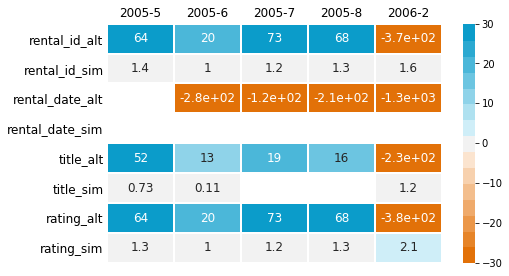

ss_dt,2005-5,2005-6,2005-7,2005-8,2006-2
rental_id_alt,63.93,19.690,73.24,67.730,-370.880
rental_id_sim,1.38,1.040,1.18,1.340,1.650
rental_date_alt,NaN,-275.000,-121.43,-210.000,-1300.000
rental_date_sim,NaN,NaN,NaN,NaN,NaN
title_alt,52.48,13.110,19.10,15.660,-225.600
title_sim,0.73,0.110,NaN,NaN,1.190
rating_alt,64.20,19.742,73.19,67.748,-375.752
rating_sim,1.33,1.044,1.16,1.340,2.068


In [80]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

# Run count test
tester.run_test()

high_distinct = [('rental_date', 'rental_date', 'rental_date'),
                 ('title', 'title', 'movie')]

# Run high_distinct tests
for comparison_fields in high_distinct:
    tester.comparison_fields = comparison_fields
    tester.test_type = 'high_distinct'
    
    tester.run_test()

# Run low_distinct test
tester.comparison_fields = ('rating','rating', 'rating')
tester.test_type = 'low_distinct'
tester.run_test()

tester.summarize_results(save=False)

Blank cells mean that the values for the test match.

In [20]:
tester._priority_review

{'count_alt': 'PRIORITY REVIEW on alt_count: 67.73',
 'rental_date_alt': 'PRIORITY REVIEW on alt_rental_date: 242.5',
 'title_alt': 'PRIORITY REVIEW on alt_title: 19.1'}

### Manage `low_distinct` tests

In [51]:
tester.comparison_fields = ('rating','rating', 'rating')
tester.test_type = 'low_distinct'
tester.run_test()

Commencing test for low_distinct rating...
   Commencing rating query...
   Query for rating complete.
PRIORITY REVIEW on alt_rating: 68.72
Test for rating complete.



In [52]:
tester._results

,date,ss_dt,rvw_rating,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,G,212,73,210,139,65.57,2,0.94
1,04-Aug-19,2005-5,PG-13,265,115,257,150,56.60,8,3.02
2,04-Aug-19,2005-5,R,227,71,225,156,68.72,2,0.88
3,04-Aug-19,2005-5,NC-17,236,83,235,153,64.83,1,0.42
4,04-Aug-19,2005-5,PG,216,75,213,141,65.28,3,1.39
5,04-Aug-19,2005-6,NC-17,463,382,459,81,17.49,4,0.86
6,04-Aug-19,2005-6,R,479,379,468,100,20.88,11,2.30
7,04-Aug-19,2005-6,PG-13,517,416,515,101,19.54,2,0.39
8,04-Aug-19,2005-6,G,393,308,389,85,21.63,4,1.02
9,04-Aug-19,2005-6,PG,459,371,456,88,19.17,3,0.65


In [56]:
tester._results.fillna(0).groupby('ss_dt')[['perc_diff_alt', 'perc_diff_sim']].mean().replace(0, np.nan).reset_index()

,ss_dt,perc_diff_alt,perc_diff_sim
0,2005-5,64.200,1.330
1,2005-6,19.742,1.044
2,2005-7,73.190,1.160
3,2005-8,67.748,1.340
4,2006-2,-375.752,2.068
